In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

import os, sys, re, pickle, glob
import urllib.request
import zipfile
from pathlib import Path

import IPython.display as ipd
from tqdm import tqdm
import librosa

In [73]:
def automation_potter(string):
    take_num = re.search("(?<![0-9S])(\d)(?![0-9])",string)
    S_num = re.search("(S\d+)",string)
    w_or_h = None
    if 'hum' in string or 'Hum' in string:
        w_or_h = 'hum'
    else:
        w_or_h = 'whistle'
    return S_num.group()+'_'+w_or_h+'_'+take_num.group()+'_'+'StarWars.wav'

In [57]:
automation_potter('S42_Hum3_Potter.wav')
automation_potter('S55_harrypotter_whistle_1')
automation_potter('S8_hum_1_[Potter].wav')
automation_potter('S18_Whistle_2_StarWars')

'S18_whistle_2_StarWars.wav'

In [58]:
dataFolder = Path(r'C:\Users\ellio\Documents\MLHW\StarWars_1')
pot_names = os.listdir(dataFolder)
# for x in pot_names:
#     print(x)

In [59]:
for x in os.listdir(dataFolder):
    old_name = os.path.join(dataFolder, x)
    new_name = os.path.join(dataFolder, automation_potter(x))
    #print(new_name)
    #full_path = os.path.join(dataFolder, os.listdir(dataFolder)[i])
    #print(full_path)
    #print(automation_potter(os.listdir(dataFolder)[i]))
    #print(automation_potter(pot_names[i]))
    #new_name = full_path.replace(os.listdir(dataFolder)[i], automation_potter(os.listdir(dataFolder)[i]))
    #os.rename(old_name,new_name)

In [60]:
# for path in os.listdir(dataFolder):
#     print(path)

In [61]:
sample_path = '/Users/ellio/Documents/MLHW/STP/*.wav'
files = glob.glob(sample_path)
len(files)
#print(files)

420

In [62]:
MLENDHW_table = [] 

for file in files:
    file_name = file.split('\\')[-1]
    #print(file_name.split('_'))
    participant_ID = file_name.split('_')[0]
    interpretation_type = file_name.split('_')[1]
    interpretation_number = file_name.split('_')[2]
    #print(re.search("\w+?(?=\.wav)",file_name.split('_')[3]).group())
    song = re.search("\w+?(?=\.wav)",file_name.split('_')[3]).group()
    MLENDHW_table.append([file_name,participant_ID,interpretation_type,interpretation_number, song])

In [86]:
MLENDHW_df = pd.DataFrame(MLENDHW_table,columns=['file_id','participant','interpretation','number','song']).set_index('file_id')
pd.set_option('display.max_rows', 350)
len(MLENDHW_df[(MLENDHW_df['interpretation']=='hum')&(MLENDHW_df['song']=='StarWars')])
MLENDHW_df

participant interpretation number      song
file_id                                                             
S100_hum_1_Potter.wav           S100            hum      1    Potter
S100_hum_2_Potter.wav           S100            hum      2    Potter
S100_hum_3_StarWars.wav         S100            hum      3  StarWars
S100_hum_4_StarWars.wav         S100            hum      4  StarWars
S101_hum_1_Potter.wav           S101            hum      1    Potter
...                              ...            ...    ...       ...
S99_whistle_1_Potter.wav         S99        whistle      1    Potter
S9_hum_1_Potter.wav               S9            hum      1    Potter
S9_hum_2_Potter.wav               S9            hum      2    Potter
S9_hum_3_StarWars.wav             S9            hum      3  StarWars
S9_hum_4_StarWars.wav             S9            hum      4  StarWars

[420 rows x 4 columns]

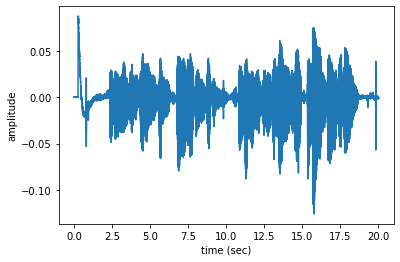

In [65]:
n=0
fs = None # Sampling frequency. If None, fs would be 22050
x, fs = librosa.load(files[n],sr=fs)
t = np.arange(len(x))/fs
plt.plot(t,x)
plt.xlabel('time (sec)')
plt.ylabel('amplitude')
plt.show()
display(ipd.Audio(files[n]))

In [66]:
MLENDHW_df.loc[files[n].split('\\')[-1]]

participant         S100
interpretation       hum
number                 1
song              Potter
Name: S100_hum_1_Potter.wav, dtype: object

In [94]:
def getPitch(x,fs,winLen=0.02):
  #winLen = 0.02 
  p = winLen*fs
  frame_length = int(2**int(p-1).bit_length())
  hop_length = frame_length//2
  f0, voiced_flag, voiced_probs = librosa.pyin(y=x, fmin=80, fmax=450, sr=fs,
                                                 frame_length=frame_length,hop_length=hop_length)
  return f0,voiced_flag

In [67]:
def getXy(files,labels_file, scale_audio=False, onlySingleDigit=False):
  X,y =[],[]
  for file in tqdm(files):
    fileID = file.split('\\')[-1]
    file_name = file.split('\\')[-1]
    #print(file_name)
    #print(labels_file.loc[fileID]['interpretation'])
    #print(labels_file.loc[fileID]['interpretation']=='hum')
    #yi = list(labels_file.loc[fileID]['interpretation'])[0]=='hum'
    yi = labels_file.loc[fileID]['song']=='Potter' 

    fs = None # if None, fs would be 22050
    x, fs = librosa.load(file,sr=fs)
    if scale_audio: x = x/np.max(np.abs(x))
    f0, voiced_flag = getPitch(x,fs,winLen=0.02)
      
    power = np.sum(x**2)/len(x)
    pitch_mean = np.nanmean(f0) if np.mean(np.isnan(f0))<1 else 0
    pitch_std  = np.nanstd(f0) if np.mean(np.isnan(f0))<1 else 0
    voiced_fr = np.mean(voiced_flag)

    xi = [power,pitch_mean,pitch_std,voiced_fr]
    X.append(xi)
    y.append(yi)

  return np.array(X),np.array(y)

In [68]:
# X,y = getXy(files, labels_file=MLENDHW_df, scale_audio=True, onlySingleDigit=True)

In [89]:
X = np.load('HS_X.npy')
y = np.load('HS_y.npy')

In [99]:
df = pd.DataFrame({
    'power':X[:,0],
    'pitch_mean': X[:,1],
    'pitch_std':X[:,2],
    'voiced_fr':X[:,3],
    'y':y
})
df

power  pitch_mean  pitch_std  voiced_fr      y
0    0.013121  182.376809  49.327953   0.752028   True
1    0.004869  176.197847  46.430793   0.746699   True
2    0.004692  186.278812  47.301620   0.693992  False
3    0.005101  190.467507  58.480351   0.741087  False
4    0.027797  289.233523  79.005025   0.771298   True
..        ...         ...        ...        ...    ...
415  0.030740  385.356247  44.723389   0.683563   True
416  0.017848  139.216019  34.021903   0.492087   True
417  0.015798  142.240905  33.930519   0.593890   True
418  0.031595  168.647557  29.687797   0.588821  False
419  0.040562  161.810649  33.922793   0.642003  False

[420 rows x 5 columns]

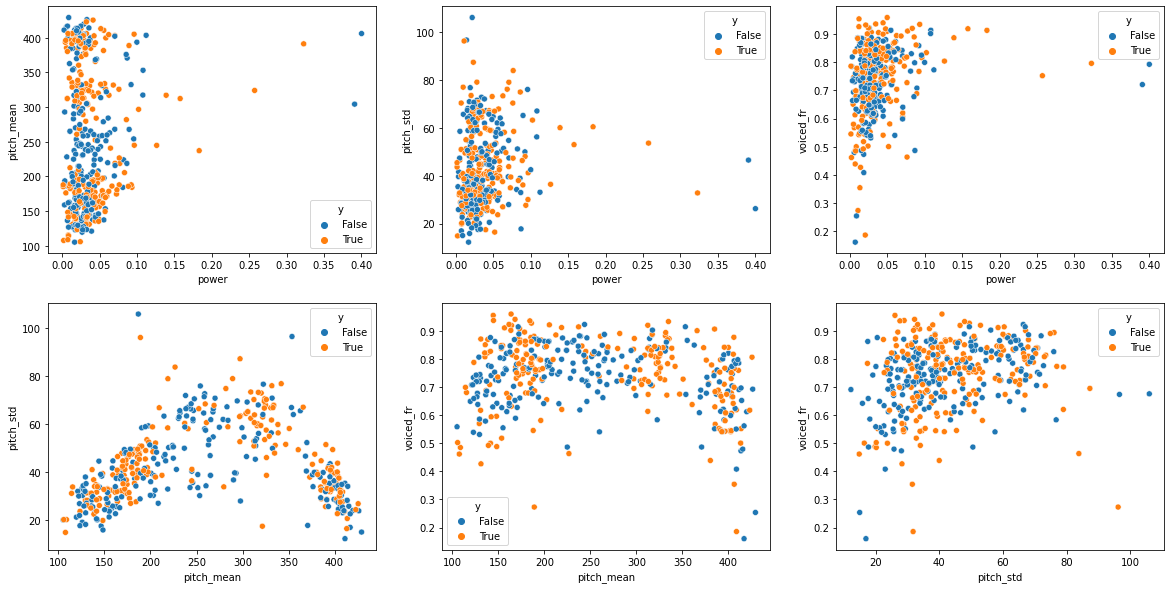

In [112]:
import seaborn as sns
fig,((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,figsize=(20,10))
ax1 = sns.scatterplot(data=df,x='power',y='pitch_mean',hue='y',ax=ax1)
ax2 = sns.scatterplot(data=df,x='power',y='pitch_std',hue='y',ax=ax2)
ax3 = sns.scatterplot(data=df,x='power',y='voiced_fr',hue='y',ax=ax3)
ax4 = sns.scatterplot(data=df,x='pitch_mean',y='pitch_std',hue='y',ax=ax4)
ax5 = sns.scatterplot(data=df,x='pitch_mean',y='voiced_fr',hue='y',ax=ax5)
ax6 = sns.scatterplot(data=df,x='pitch_std',y='voiced_fr',hue='y',ax=ax6)